<a href="https://colab.research.google.com/github/Alok180804/MajorProject/blob/main/NeravathiRiver_1970_80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import files
uploaded = files.upload()

Saving Merged_Sediment_Discharge_Data.csv to Merged_Sediment_Discharge_Data (1).csv


In [5]:
import pandas as pd

In [14]:
df_rain = pd.read_csv("Merged_Sediment_Discharge_Data.csv")
df_rain.head()

,Timestamp,Discharge_m3_s,Sediment_g_L,Sediment_tonne_day
0,1972-06-28 08:00:00,1155.0,0.1895,18910.584
1,1972-06-29 08:00:00,3320.0,0.4470,128221.056
2,1972-07-01 08:00:00,3300.0,0.3586,102244.032
3,1972-07-03 08:00:00,2700.0,0.2549,59463.072
4,1972-07-04 08:00:00,3065.0,0.3620,95863.392


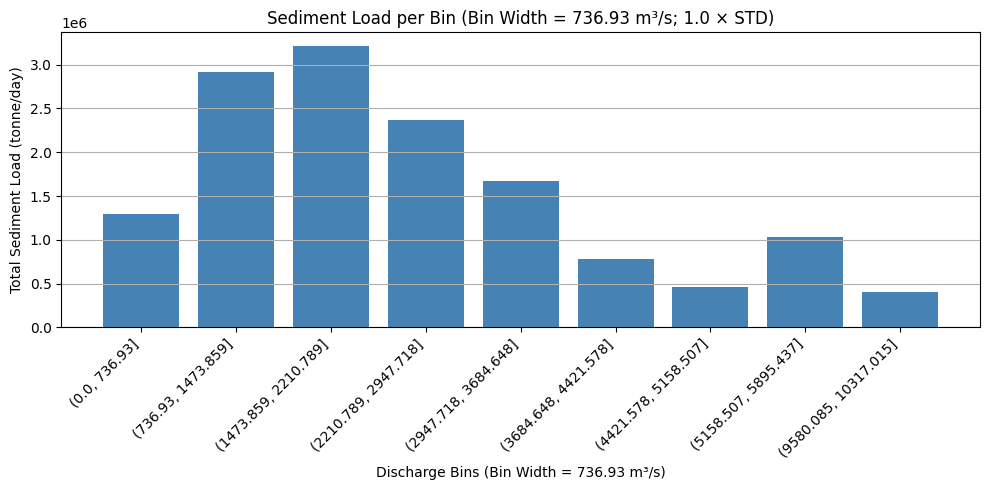

Most Sediment Load (bin width = 736.93):
Discharge_Bin               (1473.859, 2210.789]
Total_Sediment_tonne_day          3209487.331968
Name: 2, dtype: object
--------------------------------------------------------------------------------


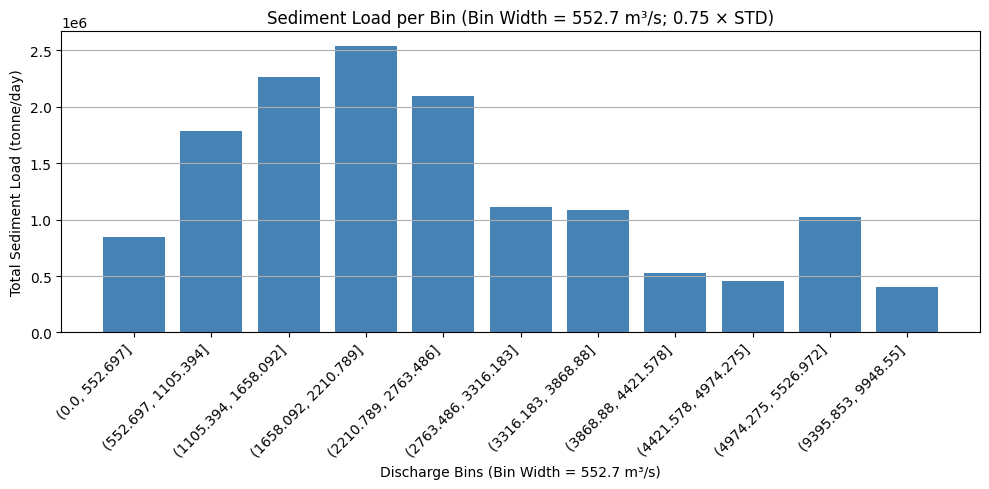

Most Sediment Load (bin width = 552.7):
Discharge_Bin               (1658.092, 2210.789]
Total_Sediment_tonne_day          2541795.157152
Name: 3, dtype: object
--------------------------------------------------------------------------------


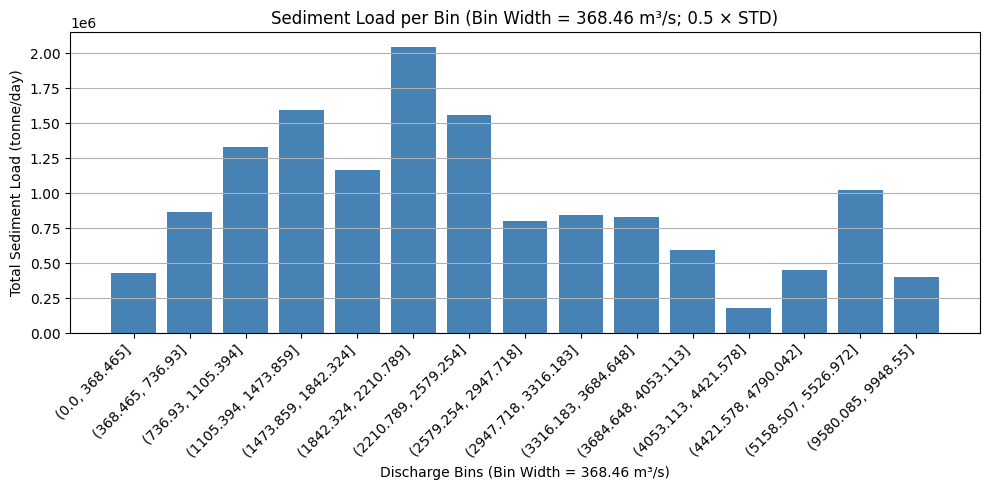

Most Sediment Load (bin width = 368.46):
Discharge_Bin               (1842.324, 2210.789]
Total_Sediment_tonne_day          2046316.607136
Name: 5, dtype: object
--------------------------------------------------------------------------------


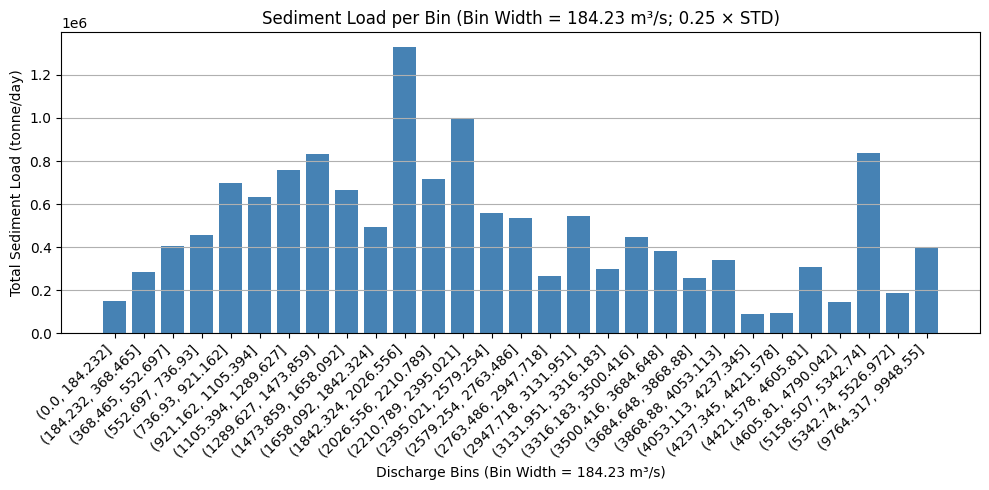

Most Sediment Load (bin width = 184.23):
Discharge_Bin               (1842.324, 2026.556]
Total_Sediment_tonne_day          1331124.122016
Name: 10, dtype: object
--------------------------------------------------------------------------------


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv("Merged_Sediment_Discharge_Data.csv")

# Drop NaNs and sort by discharge
df = df.dropna(subset=['Discharge_m3_s', 'Sediment_tonne_day'])
df = df.sort_values(by='Discharge_m3_s').reset_index(drop=True)

# Standard deviation of discharge
std_discharge = df['Discharge_m3_s'].std()
max_discharge = df['Discharge_m3_s'].max()

# Define bin widths as fractions of std deviation
bin_multiples = [1.0, 0.75, 0.5, 0.25]

# Store results
results = []

for multiple in bin_multiples:
    bin_width = multiple * std_discharge
    bin_edges = np.arange(0, max_discharge + bin_width, bin_width)

    # Bin the discharge values
    df['Discharge_Bin'] = pd.cut(df['Discharge_m3_s'], bins=bin_edges)

    # Group and sum sediment load
    binned = df.groupby('Discharge_Bin', observed=True)['Sediment_tonne_day'].sum().reset_index()
    binned.columns = ['Discharge_Bin', 'Total_Sediment_tonne_day']

    # Store for comparison
    results.append((multiple, binned))

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(binned['Discharge_Bin'].astype(str), binned['Total_Sediment_tonne_day'], color='steelblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(f"Discharge Bins (Bin Width = {round(bin_width, 2)} m³/s)")
    plt.ylabel("Total Sediment Load (tonne/day)")
    plt.title(f"Sediment Load per Bin (Bin Width = {round(bin_width, 2)} m³/s; {multiple} × STD)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Print max bin
    max_bin = binned.loc[binned['Total_Sediment_tonne_day'].idxmax()]
    print(f"Most Sediment Load (bin width = {round(bin_width, 2)}):")
    print(max_bin)
    print('-' * 80)


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Store evaluation metrics
evaluation = []

for multiple, binned_df in results:
    # Midpoint of each bin
    midpoints = binned_df['Discharge_Bin'].apply(lambda x: (x.left + x.right)/2)
    sediment = binned_df['Total_Sediment_tonne_day']

    # Linear regression to check relationship
    X = midpoints.values.reshape(-1, 1)
    y = sediment.values
    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))

    # Metrics
    num_bins = len(binned_df)
    avg_count = df['Discharge_Bin'].value_counts().mean()
    sediment_std = sediment.std()

    evaluation.append({
        'Bin_Multiple_STD': multiple,
        'Num_Bins': num_bins,
        'Avg_Count_Per_Bin': round(avg_count, 2),
        'Sediment_STD_in_Bins': round(sediment_std, 2),
        'R_squared': round(r2, 4)
    })

# Convert to DataFrame and sort by R²
evaluation_df = pd.DataFrame(evaluation).sort_values(by='R_squared', ascending=False)
print("Evaluation of Bin Sizes:")
display(evaluation_df)


📈 Evaluation of Bin Sizes:


,Bin_Multiple_STD,Num_Bins,Avg_Count_Per_Bin,Sediment_STD_in_Bins,R_squared
0,1.00,9,50.83,1046050.38,0.4606
1,0.75,11,50.83,762656.21,0.3661
2,0.50,15,50.83,517904.96,0.1882
3,0.25,29,50.83,289140.47,0.0747


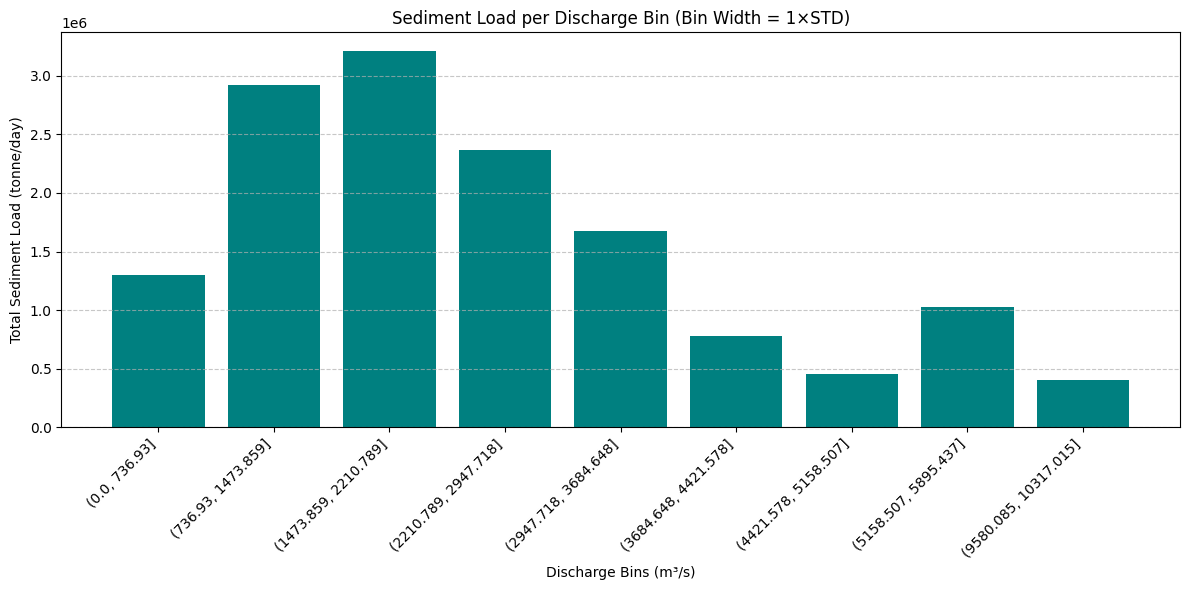

In [17]:
# Extract the binned DataFrame for multiple = 1
for multiple, binned_df in results:
    if multiple == 1.0:
        best_binned_df = binned_df.copy()
        break

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(best_binned_df['Discharge_Bin'].astype(str), best_binned_df['Total_Sediment_tonne_day'], color='teal')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Discharge Bins (m³/s)")
plt.ylabel("Total Sediment Load (tonne/day)")
plt.title("Sediment Load per Discharge Bin (Bin Width = 1×STD)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()